In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import random
import os

import math

import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string
from sklearn.preprocessing import OneHotEncoder

### First we need to read all the data to the house in question and process the data

In [14]:
def process_and_trim(LF1I, LF1V, LF2I, LF2V, TimeTicks1, TimeTicks2):
    print("Matchine the lengths...")
    min_length = min(len(LF1I), len(LF1V), len(LF2I), len(LF2V))

    # Trim the DataFrames to match the size of the smallest DataFrame, this will at most trim one or two entries
    LF1I = LF1I.head(min_length)
    LF1V = LF1V.head(min_length)
    TimeTicks1 = TimeTicks1.head(min_length)
    LF2I = LF2I.head(min_length)
    LF2V = LF2V.head(min_length)
    TimeTicks2 = TimeTicks2.head(min_length)
    print("Done!")

    print("Making volts and amps into complex numbers...")
    LF1V = np.array(LF1V)
    LF1I = np.array(LF1I)
    LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
    LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

    LF2V = np.array(LF2V)
    LF2I = np.array(LF2I)
    LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
    LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])
    print("Done!")

    print("Calculating power...")
    L1_P = LF1V * np.conjugate(LF1I)
    L2_P = LF2V * np.conjugate(LF2I)

    L1_ComplexPower = np.sum(L1_P, axis=1)
    L2_ComplexPower = np.sum(L2_P, axis=1)

    L1_real = np.real(L1_ComplexPower)
    L1_imag = np.imag(L1_ComplexPower)
    L1_app = np.abs(L1_ComplexPower)

    L2_real = np.real(L2_ComplexPower)
    L2_imag = np.imag(L2_ComplexPower)
    L2_app = np.abs(L2_ComplexPower)

    L1_Pf = np.cos(np.angle(L1_P[:, 0]))
    L2_Pf = np.cos(np.angle(L2_P[:, 0]))

    L1_actual_power = L1_real * L1_Pf
    L2_actual_power = L2_real * L2_Pf

    power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]
    print("Done!")

    return L1_actual_power, L2_actual_power, TimeTicks1, TimeTicks2, power

# Directory is the path to the directory where to house's information is
def read_files_in_directory(directory):
    labels = []
    data = []

    for root, _, files in os.walk(directory):
        if "Testing" in root:
            continue

        day_data = pd.DataFrame()
        LF1I = pd.DataFrame()
        LF1V = pd.DataFrame()
        TimeTicks1 = pd.DataFrame()
        LF2I = pd.DataFrame()
        LF2V = pd.DataFrame()
        TimeTicks2 = pd.DataFrame()
        for file in files:
            # We don't do anything with these files, so we can just skip
            if file == "TaggingInfo.csv" or "HF" in file:
                continue

            file_path = os.path.join(root, file)
            if file == "AllTaggingInfo.csv":
                print("Added labels")
                labels.append(pd.read_csv(file_path))
                continue

            if file == "LF1I.csv":
                LF1I = pd.read_csv(file_path)
                continue

            if file == "LF1V.csv":
                LF1V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks1.csv":
                TimeTicks1 = pd.read_csv(file_path)
                continue

            if file == "LF2I.csv":
                LF2I = pd.read_csv(file_path)
                continue

            if file == "LF2V.csv":
                LF2V = pd.read_csv(file_path)
                continue

            if file == "TimeTicks2.csv":
                TimeTicks2 = pd.read_csv(file_path)
                continue

        if not LF1I.empty and not LF1V.empty and not LF2I.empty and not LF2V.empty:
            print(f"{root}: ")
            L1_actual_power, L2_actual_power, TimeTicks1, TimeTicks2, power = process_and_trim(LF1I, LF1V, LF2I, LF2V, TimeTicks1, TimeTicks2)
            day_data["L1_actual_power"] = L1_actual_power
            day_data["L2_actual_power"] = L2_actual_power
            day_data["TimeTicks1"] = TimeTicks1
            day_data["TimeTicks2"] = TimeTicks2
            day_data["Power"] = power
            data.append(day_data)

    return data, labels

In [15]:
data, labels = read_files_in_directory(r".\dataset\H1")

Added labels
.\dataset\H1\Tagged_Training_04_13_1334300401: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!
.\dataset\H1\Tagged_Training_10_22_1350889201: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!
.\dataset\H1\Tagged_Training_10_23_1350975601: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!
.\dataset\H1\Tagged_Training_10_24_1351062001: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!
.\dataset\H1\Tagged_Training_10_25_1351148401: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!
.\dataset\H1\Tagged_Training_12_27_1356595201: 
Matchine the lengths...
Done!
Making volts and amps into complex numbers...
Done!
Calculating power...
Done!


In [16]:
print(labels[0])

     ApplianceID               ApplianceName     ON_Time    OFF_Time
0             30  Outside Over Garage Lights  1350939540  1350939600
1             30  Outside Over Garage Lights  1350939660  1350939720
2             30  Outside Over Garage Lights  1350939780  1350939840
3             29   Outside Front Door Lights  1350939900  1350939960
4             29   Outside Front Door Lights  1350940020  1350940080
..           ...                         ...         ...         ...
106           32             Portable Vacuum  1334356920  1334357010
107            8              Central Vacuum  1334357040  1334357070
108           35                     Toaster  1356635820  1356635880
109           35                     Toaster  1356635940  1356636000
110           35                     Toaster  1356636060  1356636120

[111 rows x 4 columns]


## Now we need to process the data, so that it's in a format that we can give to the model

In [21]:
def encode(label, total_labels):
    array = np.zeros(total_labels)
    array[label - 1] = 1
    return array

def format_data(power, time_ticks, labels, window):
    data = np.empty((len(power) // window, window))
    appliances = np.empty((len(power) // window, max(labels["ApplianceID"]) + 1))
    time = np.empty((len(power) // window, window))
    last_entry_index = 0

    for index in range(0, len(power) - window + 1, window):
        window_start = index
        window_end = index + window

        found = False
        for label in labels.iterrows():
            label = label[1]
            start_time = time_ticks[window_start].item()
            end_time = time_ticks[window_end].item()

            if label["ON_Time"] <= start_time <= label["OFF_Time"] or label["ON_Time"] <= end_time <= label["OFF_Time"]:
                found = True
                data[last_entry_index] = power[window_start:window_end]
                time[last_entry_index] = time_ticks[window_start:window_end]
                appliances[last_entry_index] = encode(label["ApplianceID"], max(labels["ApplianceID"]))
                last_entry_index += 1
                break

        # if not found:
        #     chance = random.random()
        #     if chance > 0.99:
        #         data[last_entry_index] = power[window_start:window_end].reshape(window)
        #         time[last_entry_index] = time_ticks[window_start:window_end].reshape(window)
        #         appliances[last_entry_index] = encode(0, max(labels["ApplianceID"]))
        #         last_entry_index += 1

    return data[:last_entry_index], time[:last_entry_index], appliances[:last_entry_index]

In [33]:
training_data = np.empty(0)
time = np.empty(0)
appliances = np.empty(0)

for datapoint, label in zip(data, labels):
    training_datapoint, time_datapoint, appliances_datapoint = format_data(datapoint["Power"], datapoint["TimeTicks1"], label, 10)
    training_data = np.hstack((training_data, training_datapoint))
    time = np.hstack((time, time_datapoint))
    appliances = np.hstack((appliances, appliances_datapoint))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [24]:
print(appliances)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Build the model

In [29]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(10, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(39, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Train the model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(training_data, appliances)

In [31]:
model.fit(X_train, y_train, epochs=500, batch_size=48, validation_data=(X_test, y_test))

Epoch 1/500
6/6 [==============================] - 2s 63ms/step - loss: 18.1732 - accuracy: 0.2124 - val_loss: 9.9426 - val_accuracy: 0.1724
Epoch 2/500
6/6 [==============================] - 0s 10ms/step - loss: 4.0128 - accuracy: 0.4093 - val_loss: 4.3009 - val_accuracy: 0.0460
Epoch 3/500
6/6 [==============================] - 0s 10ms/step - loss: 2.0205 - accuracy: 0.3320 - val_loss: 4.7060 - val_accuracy: 0.5172
Epoch 4/500
6/6 [==============================] - 0s 10ms/step - loss: 1.9049 - accuracy: 0.3861 - val_loss: 4.2092 - val_accuracy: 0.5172
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 1.7991 - accuracy: 0.4672 - val_loss: 3.5969 - val_accuracy: 0.5057
Epoch 6/500
6/6 [==============================] - 0s 9ms/step - loss: 1.4666 - accuracy: 0.4672 - val_loss: 3.8843 - val_accuracy: 0.5172
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 1.4464 - accuracy: 0.4247 - val_loss: 3.5271 - val_accuracy: 0.3103
Epoch 8/500
6/6 [====

In [2]:
file_path_volts1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF1V.csv"
file_path_amps1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H2\Tagged_Training_02_15_1360915201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF2V.csv"
file_path_amps2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H2\Tagged_Training_02_15_1360915201\TimeTicks2.csv"

file_path_labels = r".\dataset\H2\AllTaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

labels = pd.read_csv(file_path_labels)

In [3]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [4]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [5]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

In [6]:
print(TS1_real[0])
print(TS1_real[len(TS1_real) - 1])

print(TS2_real[0])
print(TS2_real[len(TS1_real) - 1])

2013-02-15T08:00:01.179514880
2013-02-16T07:59:58.976457984
2013-02-15T08:00:01.258717952
2013-02-16T07:59:58.607661056


In [7]:
labels["ON_Time"] = pd.to_datetime(labels["ON_Time"], unit='s')
labels["OFF_Time"] = pd.to_datetime(labels["OFF_Time"], unit='s')

In [8]:
labels.head(1000)

,ApplianceID,ApplianceName,ON_Time,OFF_Time
0,16,Kitchen Lights,2012-06-13 17:00:00,2012-06-13 17:01:00
1,16,Kitchen Lights,2012-06-13 17:02:00,2012-06-13 17:02:30
2,16,Kitchen Lights,2012-06-13 17:03:30,2012-06-13 17:04:30
3,16,Kitchen Lights,2012-06-13 17:05:30,2012-06-13 17:06:00
4,17,Kitchen Table Lights,2012-06-13 17:06:30,2012-06-13 17:07:00
...,...,...,...,...
113,6,Computer,2013-02-15 19:36:00,2013-02-15 19:37:00
114,29,Printer,2013-02-15 19:38:00,2013-02-15 19:40:30
115,29,Printer,2013-02-15 19:41:30,2013-02-15 19:43:00
116,29,Printer,2013-02-15 19:44:00,2013-02-15 19:45:00


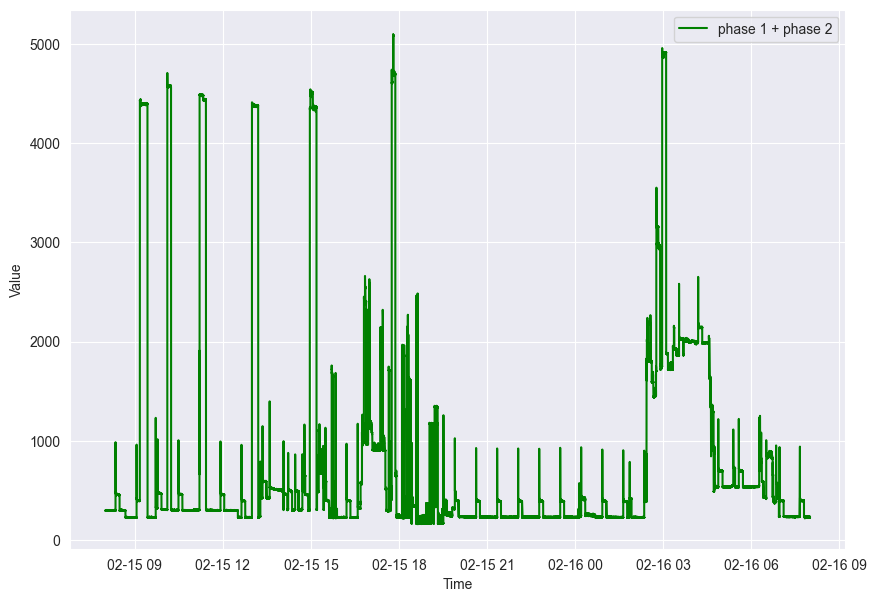

In [34]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index


start_index, end_index = zoomIn("2013-02-15 18:45:00", "2013-02-15 18:55:00", time_ticks1_np)
plt.figure(figsize=(10, 7))

#This plots total power consumption (zoomed in)
# plt.plot(TS2_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='g', label='phase 1 + phase 2')

#This plots total power consumption
plt.plot(TS1_real, power, linestyle='-', color='g', label='phase 1 + phase 2')

# This plots phase 1 and phase 2 separately (zoomed in)
# plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
# plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

# This plots phase 1 and phase 2 separately (whole thing)
# plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
# plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def moving_average(window: int, threshold: int, power):
    df = pd.DataFrame(power)
    df = df.rolling(window=window).mean()
    return df.to_numpy()

test = moving_average(20, power)
plt.figure(figsize=(10, 7))
plt.plot(TS1_real, test, linestyle='-', color='g', label='phase 1 + phase 2')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

TypeError: moving_average() missing 1 required positional argument: 'power'

In [42]:
def encode(label, total_labels):
    array = np.zeros(total_labels + 1)
    array[label] = 1
    return array

def format_data(power, time_ticks, labels, window):
    data = np.empty((len(power) // window, window))
    appliances = np.empty((len(power) // window, max(labels["ApplianceID"]) + 1))
    time = np.empty((len(power) // window, window))
    last_entry_index = 0

    for index in range(0, len(power) - window + 1, window):
        window_start = index
        window_end = index + window

        found = False
        for label in labels.iterrows():
            label = label[1]
            start_time = datetime.utcfromtimestamp(time_ticks[window_start].item())
            end_time = datetime.utcfromtimestamp(time_ticks[window_end].item())

            if label["ON_Time"] <= start_time <= label["OFF_Time"] or label["ON_Time"] <= end_time <= label["OFF_Time"]:
                found = True
                data[last_entry_index] = power[window_start:window_end].reshape(window)
                time[last_entry_index] = time_ticks[window_start:window_end].reshape(window)
                appliances[last_entry_index] = encode(label["ApplianceID"], max(labels["ApplianceID"]))
                last_entry_index += 1
                break

        # if not found:
        #     chance = random.random()
        #     if chance > 0.99:
        #         data[last_entry_index] = power[window_start:window_end].reshape(window)
        #         time[last_entry_index] = time_ticks[window_start:window_end].reshape(window)
        #         appliances[last_entry_index] = encode(0, max(labels["ApplianceID"]))
        #         last_entry_index += 1

    return data[:last_entry_index], time[:last_entry_index], appliances[:last_entry_index]

data, time, appliances = process_data(power, time_ticks1_np, labels, 10)

In [43]:
print(data)
print(appliances.shape)

[[227.01128249 226.97864164 229.18759796 ... 227.36862706 226.51124187
  229.0585733 ]
 [233.88943465 227.0682311  226.624764   ... 228.01646653 228.07221639
  227.07364906]
 [226.7405476  229.17390162 227.57545939 ... 229.80850454 227.61660306
  227.27179919]
 ...
 [257.82555045 256.37532101 254.0490028  ... 247.44726288 255.30634211
  255.72174899]
 [253.18286489 258.52368351 250.83950772 ... 249.56506619 248.14645594
  247.17518501]
 [247.51432482 247.69578722 253.49514395 ... 245.26098514 245.16106357
  252.73071368]]
(1545, 38)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, appliances)
print(X_train)
print(y_train)

[[1169.59068747 1173.06503406 1168.25841473 ... 1169.4250345
  1167.91739477 1167.81830915]
 [1347.63535086 1342.86682073 1344.85626716 ... 1342.98060145
  1343.95337127 1341.7469311 ]
 [ 234.6962654   235.18923433  235.14923044 ...  239.99873544
   234.8488575   228.01369362]
 ...
 [ 231.56137215  235.89275541  238.06208049 ...  235.94101108
   236.60048765  234.46935943]
 [ 226.4378199   227.23576958  228.9738267  ...  228.48407752
   228.78074519  230.62463554]
 [ 248.26781285  248.03429699  244.04835821 ...  246.85250753
   246.30576173  245.75636026]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
count = 0
for index in range(len(appliances)):
    if appliances[index][0] != 1:
        count += 1

print(count)

1545


In [54]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(10, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(38, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
model.fit(X_train, y_train, epochs=500, batch_size=48, validation_data=(X_test, y_test))

Epoch 1/500
25/25 [==============================] - 0s 8ms/step - loss: 0.8365 - accuracy: 0.6900 - val_loss: 3.2745 - val_accuracy: 0.5866
Epoch 2/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7467 - accuracy: 0.7202 - val_loss: 3.2043 - val_accuracy: 0.6796
Epoch 3/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7233 - accuracy: 0.7314 - val_loss: 3.2729 - val_accuracy: 0.6382
Epoch 4/500
25/25 [==============================] - 0s 6ms/step - loss: 0.7176 - accuracy: 0.7280 - val_loss: 3.3531 - val_accuracy: 0.6744
Epoch 5/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7283 - accuracy: 0.7306 - val_loss: 3.3349 - val_accuracy: 0.6408
Epoch 6/500
25/25 [==============================] - 0s 5ms/step - loss: 0.7550 - accuracy: 0.7142 - val_loss: 3.2759 - val_accuracy: 0.6434
Epoch 7/500
25/25 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.7366 - val_loss: 3.4485 - val_accuracy: 0.6563
Epoch 8/500
2

In [57]:
# Reshape X_test to match the model's input shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 10, 1)

# Now, you can use model.predict() on the reshaped X_test data
predictions = model.predict(X_test_reshaped)

# Find the class with the highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class as an integer
for i, predicted_class in enumerate(predicted_classes):
    print(f"Prediction {i + 1}: Class {predicted_class}")

13/13 [==============================] - 0s 1ms/step
Prediction 1: Class 18
Prediction 2: Class 5
Prediction 3: Class 6
Prediction 4: Class 5
Prediction 5: Class 5
Prediction 6: Class 29
Prediction 7: Class 7
Prediction 8: Class 8
Prediction 9: Class 18
Prediction 10: Class 6
Prediction 11: Class 33
Prediction 12: Class 6
Prediction 13: Class 5
Prediction 14: Class 29
Prediction 15: Class 18
Prediction 16: Class 21
Prediction 17: Class 5
Prediction 18: Class 5
Prediction 19: Class 29
Prediction 20: Class 32
Prediction 21: Class 5
Prediction 22: Class 5
Prediction 23: Class 7
Prediction 24: Class 7
Prediction 25: Class 18
Prediction 26: Class 21
Prediction 27: Class 5
Prediction 28: Class 29
Prediction 29: Class 5
Prediction 30: Class 5
Prediction 31: Class 18
Prediction 32: Class 5
Prediction 33: Class 18
Prediction 34: Class 6
Prediction 35: Class 21
Prediction 36: Class 18
Prediction 37: Class 6
Prediction 38: Class 18
Prediction 39: Class 18
Prediction 40: Class 7
Prediction 41: Cla